In [14]:
# Run this cell to import modules for the notebook.

### Imports ###
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Loading in the data.
RAW_CMS2020_DF = pd.read_csv('data2.csv')

In [16]:
# Because of the filtering of the dataset, many columns do not have any 
# information in them and are worthless to the analysis.
pd.options.mode.chained_assignment = None

CMS2020_DF = RAW_CMS2020_DF.dropna(how='all', axis=1)
CMS2020_DF.drop(CMS2020_DF.filter(regex='2').columns, axis=1, inplace=True)
CMS2020_DF.drop(CMS2020_DF.filter(regex='3').columns, axis=1, inplace=True)
CMS2020_DF.drop(CMS2020_DF.filter(regex='4').columns, axis=1, inplace=True)
CMS2020_DF.drop(CMS2020_DF.filter(regex='5').columns, axis=1, inplace=True)
print(f'The raw data contains {len(RAW_CMS2020_DF.columns)} columns and the pruned data contains {len(CMS2020_DF.columns)} columns')
CMS2020_DF.head()

The raw data contains 30 columns and the pruned data contains 27 columns


,change_type,physician_profile_id,physician_npi,physician_first_name,physician_middle_name,physician_last_name,physician_name_suffix,recipient_primary_business_street_address_line1,recipient_city,recipient_state,...,value_of_interest,terms_of_interest,submitting_applicable_manufacturer_or_applicable_gpo_name,applicable_manufacturer_or_applicable_gpo_making_payment_id,applicable_manufacturer_or_applicable_gpo_making_payment_name,applicable_manufacturer_or_applicable_gpo_making_payment_state,applicable_manufacturer_or_applicable_gpo_making_payment_country,dispute_status_for_publication,interest_held_by_physician_or_an_immediate_family_member,payment_publication_date
0,UNCHANGED,1187636,1.962423e+09,Dhananjaya,NaN,Kamisetti,NaN,30 S Cayuga Rd,Williamsville,NY,...,656068.0,Common and Preferred Shares,"Romark Laboratories, LC",100000011162,"Romark Laboratories, LC",FL,United States,No,Physician Covered Recipient,01/20/2023
1,UNCHANGED,795781,1.194775e+09,Sharad,NaN,Lakdawala,NaN,2908 W Waters Ave,Tampa,FL,...,326530.0,Common and Preferred Shares,"Romark Laboratories, LC",100000011162,"Romark Laboratories, LC",FL,United States,No,Physician Covered Recipient,01/20/2023
2,UNCHANGED,1031473,1.467643e+09,Kenneth,NaN,Liszewski,NaN,1880 Arlington St,Sarasota,FL,...,653060.0,Common and Preferred Shares,"Romark Laboratories, LC",100000011162,"Romark Laboratories, LC",FL,United States,No,Physician Covered Recipient,01/20/2023
3,UNCHANGED,372257,1.295736e+09,Jose,NaN,Matos,NaN,EDIF Capital Center,San Juan,PR,...,392346.0,Common and Preferred Shares,"Romark Laboratories, LC",100000011162,"Romark Laboratories, LC",FL,United States,No,Physician Covered Recipient,01/20/2023
4,UNCHANGED,658330,1.356395e+09,Mark,NaN,McCutcheon,NaN,5100 Rangeline Service Rd N,Mobile,AL,...,238548.0,Common and Preferred Shares,"Romark Laboratories, LC",100000011162,"Romark Laboratories, LC",FL,United States,No,Physician Covered Recipient,01/20/2023


In [20]:
# Basic statisical details about the overall data.
total_payments = len(CMS2020_DF)
total_value = CMS2020_DF.total_amount_invested_usdollars.sum()
total_mean = round(np.mean(CMS2020_DF.total_amount_invested_usdollars), 2)
total_median = round(np.median(CMS2020_DF.total_amount_invested_usdollars), 2)
total_std = round(np.std(CMS2020_DF.total_amount_invested_usdollars), 2)
total_min = np.min(CMS2020_DF.total_amount_invested_usdollars)
total_max = np.max(CMS2020_DF.total_amount_invested_usdollars)

print(f'There are {total_payments} individual payments to physicians with a total valuation of ${total_value} for non-consulting services in the Open Payments 2020 dataset.')
print(f'The average value for this service is ~ ${total_mean}')
print(f'The median value for this service is ~ ${total_median}')
print(f'The standard deviation for this service is ${total_std}')
print(f'The smallest value for this service is ${total_min}')
print(f'The largest value for this service is ${total_max}')

There are 3377 individual payments to physicians with a total valuation of $422534419.29999995 for non-consulting services in the Open Payments 2020 dataset.
The average value for this service is ~ $125121.24
The median value for this service is ~ $0.0
The standard deviation for this service is $4999893.23
The smallest value for this service is $0.0
The largest value for this service is $290386425.13


In [21]:
def full_name(physician_profile_id: int):
    '''Return the physicians full name given their profile id.'''

    # Gather the parts to a physicians name.
    query = CMS2020_DF.query(f'physician_profile_id == @physician_profile_id')
    
    first = query.physician_first_name.values[0]
    middle = query.physician_middle_name.values[0]
    last = query.physician_last_name.values[0]

    # Filter out any parts of the name that are considered NaN.
    part_lst = [first, middle, last]
    name_parts = [part for part in part_lst if isinstance(part, str)]

    # Join the parts together.
    name = ' '.join(name_parts).upper()

    return name

In [28]:
# To find the next Physician Idol we need to find the physician from each state that has the most payments

# Initial dataframe creation.
state_lst = CMS2020_DF.recipient_state.unique()
state_champs_df = pd.DataFrame({
    'state': [],
    'name': [],
    'physician_profile_id': [],
    'physician_specialty': [],
    'appearances': [],
    'total_value': [],
    'value_mean': [],
    'value_median': [],
    'value_min': [],
    'value_max': [],
    'value_std': [],
    'top_contractor': [],
    'top_product_cat': [],
    'top_product_name': []
})

# For loop to find the top physician from each state.
for state in state_lst:
    # Get the dataframe of the data just for that state.
    state_df = CMS2020_DF.query('recipient_state == @state')

    # Get the id of the physician with the most payments in the state and get their dataframe.
    top_physician_id = state_df.physician_profile_id.mode()[0]
    top_physician_df = state_df.query('physician_profile_id == @top_physician_id')

    # How many entries this physician has, their specialty and their full name.
    appearances = len(top_physician_df)
    physician_specialty = top_physician_df.physician_specialty.values[0]
    name = full_name(top_physician_id)

    # The total valuation of the physician's services and related metrics.
    total_service_value = round(top_physician_df.total_amount_invested_usdollars.sum(), 2)
    service_value_mean = round(np.mean(top_physician_df.total_amount_invested_usdollars), 2)
    service_value_median = round(np.median(top_physician_df.total_amount_invested_usdollars), 2)
    service_value_min = np.min(top_physician_df.total_amount_invested_usdollars)
    service_value_max = np.max(top_physician_df.total_amount_invested_usdollars)
    service_value_std = np.std(top_physician_df.total_amount_invested_usdollars)

    # Top categorical data.
    top_manufacturer_gpo = top_physician_df.submitting_applicable_manufacturer_or_applicable_gpo_name.mode()[0]
    # try:
    #     top_product_category = top_physician_df.indicate_drug_or_biological_or_device_or_medical_supply_1.value_counts().index[0]
    # except IndexError:
    #     top_product_cateogory = 'None'
    # try:
    #     top_product_name = top_physician_df.name_of_drug_or_biological_or_device_or_medical_supply_1.value_counts().index[0]
    # except IndexError:
    #     top_product_name = 'None'

    # Create the entry to append to the data frame of state champs.
    physician_entry = {
        'state': [state],
        'name': [name],
        'physician_profile_id': [top_physician_id],
        'physician_specialty': [physician_specialty],
        'appearances': [appearances],
        'total_value': [total_service_value],
        'value_mean': [service_value_mean],
        'value_median': [service_value_median],
        'value_min': [service_value_min],
        'value_max': [service_value_max],
        'value_std': [service_value_std],
        'top_contractor': [top_manufacturer_gpo],
        # 'top_product_cat': [top_product_category],
        # 'top_product_name': [top_product_name]
    }

    physician_entry_df = pd.DataFrame(physician_entry)
    state_champs_df = pd.concat([state_champs_df, physician_entry_df], ignore_index=True)

state_champs_df.physician_profile_id = state_champs_df.physician_profile_id.astype(int)
state_champs_df.appearances = state_champs_df.appearances.astype(int)
state_champs_df.sort_values('appearances', inplace=True, ascending=False)
state_champs_df.reset_index(inplace=True)
state_champs_df.drop(columns=['index'], inplace=True)
state_champs_df.head(30)

,state,name,physician_profile_id,physician_specialty,appearances,total_value,value_mean,value_median,value_min,value_max,value_std,top_contractor,top_product_cat,top_product_name
0,CA,JOHN STEINMANN,355094,NaN,10,1891.90,189.19,0.00,0.00,1371.94,407.718422,"Central California Surgical Distributors, LLC",NaN,NaN
1,NC,CATHERINE RAINBOW,978338,Allopathic & Osteopathic Physicians|Family Med...,8,2637.00,329.62,0.00,0.00,2637.00,872.105776,Innovation Technologies Inc,NaN,NaN
2,NJ,SEAN MCMILLAN,923685,Allopathic & Osteopathic Physicians|Orthopaedi...,8,80000.00,10000.00,0.00,0.00,80000.00,26457.513111,"Trice Medical, Inc.",NaN,NaN
3,TX,MICHAEL SCHWARTZ,337143,Allopathic & Osteopathic Physicians|Orthopaedi...,6,200000.00,33333.33,0.00,0.00,200000.00,74535.599250,"Trice Medical, Inc.",NaN,NaN
4,NY,LEO NELSON HOPKINS,88719,Allopathic & Osteopathic Physicians|Neurologic...,5,139256.84,27851.37,0.00,0.00,135399.60,53794.863106,"Imperative Care, Inc",NaN,NaN
5,NM,DOUGLAS DODSON,758310,NaN,5,116.42,23.28,0.00,0.00,93.25,36.115615,"Central California Surgical Distributors, LLC",NaN,NaN
6,FL,LARRY POPEIL,1113491,Allopathic & Osteopathic Physicians|Family Med...,5,0.00,0.00,0.00,0.00,0.00,0.000000,Innovation Technologies Inc,NaN,NaN
7,CO,BRYAN A CASTRO,242579,NaN,5,116.42,23.28,0.00,0.00,93.25,36.115615,"Central California Surgical Distributors, LLC",NaN,NaN
8,KY,PAUL KARPECKI,73016,Eye and Vision Services Providers|Optometrist,5,30335.00,6067.00,85.00,0.00,30000.00,11966.754197,Amaros Medical,NaN,NaN
9,MS,TAMIR TAWFIK,761194,Allopathic & Osteopathic Physicians|Neurologic...,4,295000.00,73750.00,75000.00,0.00,145000.00,54241.934884,"Amplify Surgical, Inc.",NaN,NaN


In [29]:
# Fonts
label_font = {
        'family': 'Lato',
        'weight': 'bold',
        'size': 14
        }
title_font = {
        'family': 'Lato',
        'weight': 'bold',
        'size': 20
        }
bar_font = {
        'family': 'monospace',
        'weight': 'bold',
        'stretch': 'expanded',
        'color': 'w',
        'size': 12
    }

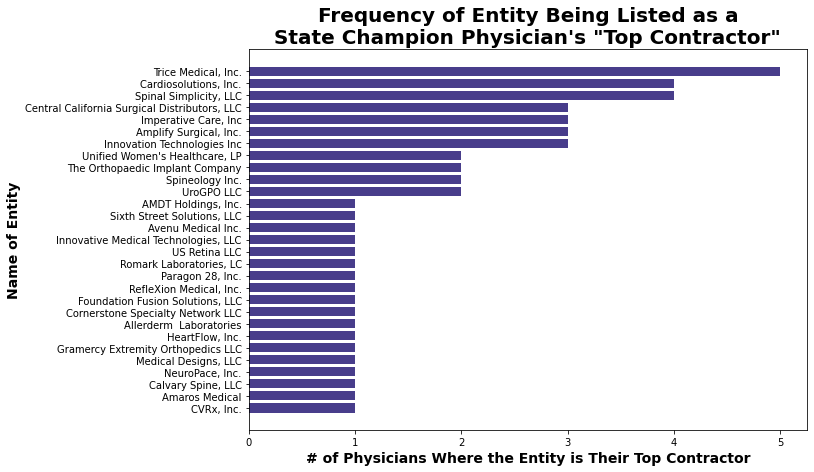

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.invert_yaxis()

plt.title('Frequency of Entity Being Listed as a\nState Champion Physician\'s "Top Contractor"', fontdict=title_font)
plt.xlabel('# of Physicians Where the Entity is Their Top Contractor', fontdict=label_font)
plt.ylabel('Name of Entity', fontdict=label_font)

entities_ax_x = state_champs_df.top_contractor.value_counts()
entities_ax_y = state_champs_df.top_contractor.value_counts().index

top_entities_hbar = plt.barh(entities_ax_y, entities_ax_x, facecolor='darkslateblue')
top_contracting_entities_bar_labels = state_champs_df.top_contractor.value_counts().values
plt.savefig("TOP_CONTRACTING_ENTITIES.png", dpi=300, bbox_inches = 'tight')

In [39]:
# Money spent by Trice Medical Inc.

trice_df = CMS2020_DF[CMS2020_DF.submitting_applicable_manufacturer_or_applicable_gpo_name == 'Trice Medical, Inc.']
total_payments = len(trice_df.total_amount_invested_usdollars)
payment_sum = round(trice_df.total_amount_invested_usdollars.sum(), 2)

print(f'Trice Medical Inc made {total_payments} payments summing up to a valuation of ${payment_sum}')

el_mean_payments = round(np.mean(trice_df.total_amount_invested_usdollars.values), 2)
el_median_payments = round(np.median(trice_df.total_amount_invested_usdollars.values), 2)
el_std_dev_payments = round(np.std(trice_df.total_amount_invested_usdollars.values), 2)

print(f'The mean and median of these payments is ${el_mean_payments} and ${el_median_payments} respectively with a standard deviation of ${el_std_dev_payments}.')

Trice Medical Inc made 69 payments summing up to a valuation of $1174781.83
The mean and median of these payments is $17025.82 and $0.0 respectively with a standard deviation of $61518.21.


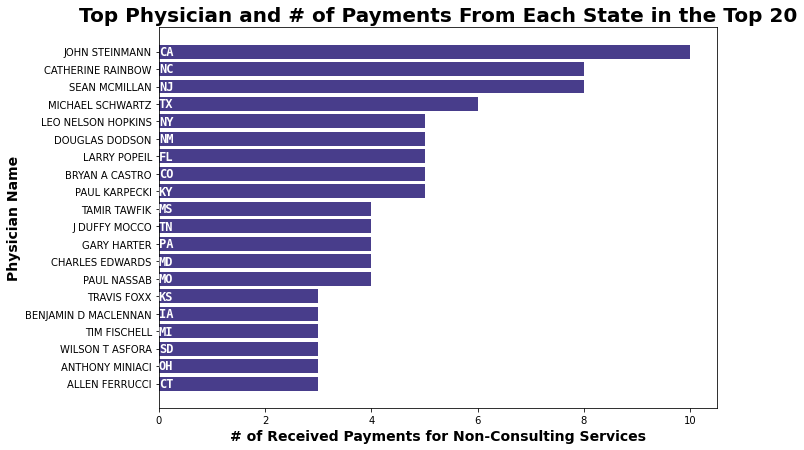

In [51]:
# Where does the money go
fig, ax = plt.subplots(figsize=(10, 7))

ax.invert_yaxis()
ax_y = state_champs_df.name.values[:20]
ax_x = state_champs_df.appearances.values[:20]
top_phys_bar_labels = state_champs_df.state.values[:20]

plt.title('Top Physician and # of Payments From Each State in the Top 20', fontdict=title_font)
plt.xlabel('# of Received Payments for Non-Consulting Services', fontdict=label_font)
plt.ylabel('Physician Name', fontdict=label_font)

hbar_plot = plt.barh(ax_y, ax_x, facecolor='darkslateblue')

def barh_autolabel(bars: plt, bar_labels: list = top_phys_bar_labels, width_adjust: float = 10.0, height_adjust: float = 0.75):
    '''A function for labeling the end of each bar with the state the physician is from.'''

    for count, bar in enumerate(bars):
        width = bar.get_width()
        height = bar.get_height()
        x_pos = width - width_adjust
        y_pos = bar.get_y() + height * height_adjust
        
        state_text = bar_labels[count]

        plt.text(0, y_pos, state_text, fontdict=bar_font)

barh_autolabel(hbar_plot)
plt.savefig("TOP_PHYSICIANS_BY_STATE.png", dpi=300, bbox_inches = 'tight')



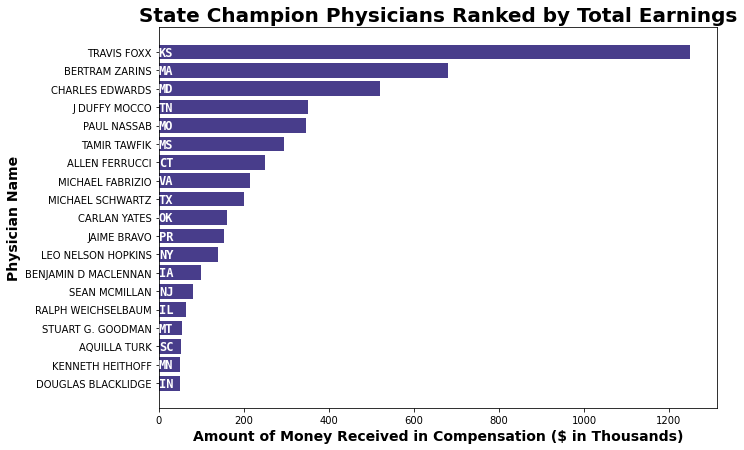

In [50]:
plt.close()

scp_money_df = state_champs_df.sort_values('total_value')

fig, ax = plt.subplots(figsize=(10, 7))
ax_y = scp_money_df.name.values[32:]
ax_x = [(int(val) / 1000) for val in scp_money_df.total_value.values[32:]]
top_phys_val_bar_labels = scp_money_df.state.values[32:]

plt.title('State Champion Physicians Ranked by Total Earnings', fontdict=title_font)
plt.xlabel('Amount of Money Received in Compensation ($ in Thousands)', fontdict=label_font)
plt.ylabel('Physician Name', fontdict=label_font)

hbar_plot = plt.barh(ax_y, ax_x, facecolor='darkslateblue')

def bar_labeler(bars: plt):
    '''Labels the figure of this cell.'''

    for count, bar in enumerate(bars):
        val_width = bar.get_width()
        val_height = bar.get_height()
        val_x_pos = val_width * 0.9
        val_y_pos = bar.get_y() + val_height * 0.25
        
        state_text = top_phys_val_bar_labels[count]

        plt.text(0, val_y_pos, state_text, fontdict=bar_font)

bar_labeler(hbar_plot)


#plt.savefig("TOP PHYSICIANS BY EARNINGS.png", dpi=300, bbox_inches='tight')

In [49]:
scp_mean_payment = round(np.mean(state_champs_df.value_mean.values), 2)
scp_median_payment = round(np.median(state_champs_df.value_mean.values), 2)
scp_std_dev_payment = round(np.std(state_champs_df.value_mean.values), 2)
print(f'The mean and median of the SCP mean value payments are ${scp_mean_payment} and ${scp_median_payment} respectively with a standard deviation of ${scp_std_dev_payment}')

The mean and median of the SCP mean value payments are $34573.17 and $3750.0 respectively with a standard deviation of $70685.51


In [ ]:
# <!--  -->
# <!-- 
# - SQL pipeline up and running
# - Payments by fields / disciplines categorization + temporal analysis 2013-2020
# - Hospitals/states + geographic regions
# - TDA proof of concept: create graph with mapper algorithm for this specific csv dataset
# - Are doctors getting paid to use the tech or are they using the tech and getting paid for it?
# - Patient claims
#  -->